# Машинное обучение в бизнесе

## Урок 5. Задача оттока: варианты постановки, возможные способы решения

__Домашнее задание__

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

__Ссылки__

http://hyperopt.github.io/hyperopt/<br>
https://arxiv.org/pdf/1907.03947.pdf<br>
https://arxiv.org/pdf/1802.02301.pdf<br>
https://arxiv.org/list/stat.ML/recent<br>
https://scikit-learn.org/stable/modules/grid_search.html<br>
https://scikit-learn.org/stable/modules/compose.html

## <center> Практическое задание </center>

# 
## 1 Задание

Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

### Case 1

Набором данных с платформы kaggle https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers по оттоку клиентов банка

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("../lection5_materials/churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить.

Посмотрим на распределение классов:

In [3]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [5]:
# #разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [6]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [7]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Зададим списки признаков

In [8]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Посмотрим как это работает на примере отдельного категориального признака - Gender

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


Аналогичный пример для вещественного признака (здесь мы не применяем какое-либо преобразование, а просто столбец как есть)

Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)

In [10]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [11]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим модель

# 
## 1 Задание

Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

__Отмасштабируем получившиеся признаки методом нормализации.__

In [12]:
# Находим минимальное и максимальное значение для каждого признака
def dataset_minmax(dataset):
    minmax = list()
    for i in range(len(dataset[0])):
        col_values = [row[i] for row in dataset]
        value_min = min(col_values)
        value_max = max(col_values)
        minmax.append([value_min, value_max])

    return minmax

In [13]:
# Находим минимальное и максимальное значение для каждого признака
def dataset_minmax(dataset, field):
    minmax = list()
    for i in range(df[field].shape[1]):
        value_min = df[field[i]].min()
        value_max = df[field[i]].max()
        minmax.append([value_min, value_max])

    return minmax

# Нормализация датасета (0-1)
def normalize_dataset(dataset, minmax, field):

    for i in range(dataset[field].shape[1]):
        X_min = minmax[i][0]
        X_max = minmax[i][1]

        dataset[field[i]] = pd.Series((dataset[field[i]] - X_min) / ( X_max - X_min))

In [14]:
# Находим минимальное и максимальное значение для каждого признака
fields = ['Balance','EstimatedSalary']

minmax = dataset_minmax(df, fields)
minmax

[[0.0, 250898.09], [11.58, 199992.48]]

In [15]:
# Нормализация датасета (0-1)
normalize_dataset(X_train, minmax, fields)
X_train[fields].head(3)

<ipython-input-13-dd884222db8a>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[field[i]] = pd.Series((dataset[field[i]] - X_min) / ( X_max - X_min))


,Balance,EstimatedSalary
2967,0.469646,0.029100
700,0.000000,0.478045
3481,0.212437,0.214242


In [16]:
# Нормализация датасета (0-1)
normalize_dataset(X_test, minmax, fields)
X_test[fields].head(3)

<ipython-input-13-dd884222db8a>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[field[i]] = pd.Series((dataset[field[i]] - X_min) / ( X_max - X_min))


,Balance,EstimatedSalary
9394,0.522527,0.964298
898,0.410395,0.643514
2398,0.380182,0.378640


In [17]:
def calc_std_feat(x):
    '''
    Масштабирование признаков методом стандартизации
    
    '''
    
    res = (x - x.mean()) / x.std()
    return res

In [18]:
# df.info()

In [19]:
def normalizations(df, field):
    '''
    Масштабирование признаков методом нормализации
    
    '''

    for i in range(df[field].shape[1]):
        X_min = df[field[i]].min()
        X_max = df[field[i]].max()

        df[field[i]] = pd.Series((df[field[i]] - X_min) / ( X_max - X_min))

In [20]:
fields = ['Balance','EstimatedSalary']
# normalizations(df, fields)
# normalizations(X_train, fields)
# normalizations(X_test, fields)

In [21]:
X_train[fields].head(3)

,Balance,EstimatedSalary
2967,0.469646,0.029100
700,0.000000,0.478045
3481,0.212437,0.214242


In [22]:
X_test[fields].head(3)

,Balance,EstimatedSalary
9394,0.522527,0.964298
898,0.410395,0.643514
2398,0.380182,0.378640


In [23]:
# 2 простых способа нормализовать данные в Python
# https://dev-gang.ru/article/-prostyh-sposoba-normalizovat-dannye-v-python-7qqrhmlppl/
from sklearn import preprocessing

In [24]:
# fields = ['Balance','EstimatedSalary']
# d = preprocessing.normalize(df[fields], axis=0)
# scaled_df = pd.DataFrame(d, columns=fields)
# scaled_df.head(3)

### Случайный лес

In [25]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

Обучим модель

In [26]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [27]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.37, 0.26, 0.16, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [28]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [29]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.380000, F-Score=0.641, Precision=0.653, Recall=0.629


Отрисуем матрицу ошибок

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1832  159]
 [ 195  314]]


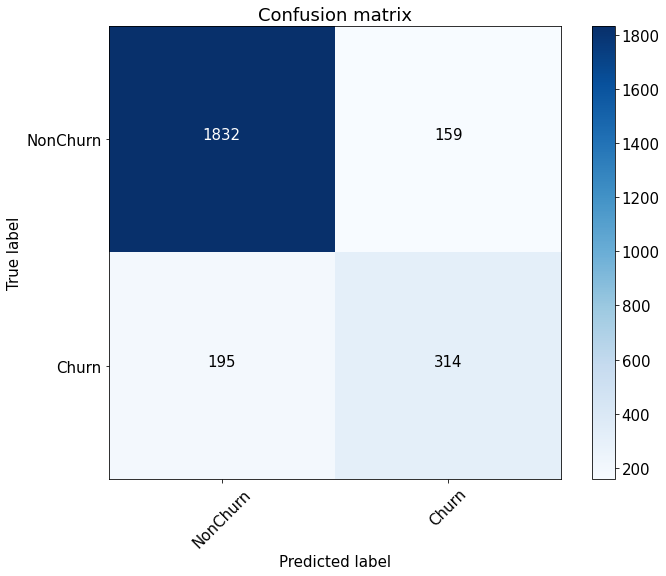

In [31]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [32]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]
print(f'{TP}(TP) {FP}(FP)\n{FN}(FN) {TN}(TN)')


314(TP) 159(FP)
195(FN) 1832(TN)


In [33]:
models_results = {
    'model': [],
    'precision': [],
    'recall': [],
    'f-score': [],
    'thresholds': [],
}

In [34]:
models_results

{'model': [], 'precision': [], 'recall': [], 'f-score': [], 'thresholds': []}

In [35]:
models_results['model'].append('RandomForest')
models_results['precision'].append(precision[ix])
models_results['recall'].append(recall[ix])
models_results['f-score'].append(fscore[ix])
models_results['thresholds'].append(thresholds[ix])

In [36]:
pd.DataFrame(data=models_results).sort_values('precision', ascending=False)

,model,precision,recall,f-score,thresholds
0,RandomForest,0.653061,0.628684,0.640641,0.38


# 
## 1 Задание

Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

### 1.1 - бустинг

*XGBoost*

In [37]:
import xgboost as xgb 

In [38]:
# pipeline = Pipeline([
#     ('features',feats),
#     ('classifier', RandomForestClassifier(random_state = 42)),
# ])

classifier_xgb = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBClassifier(random_state=21))
])

Обучим модель

In [39]:
#обучим наш пайплайн
classifier_xgb.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:35:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [40]:
#наши прогнозы для тестовой выборки
preds_xgb = classifier_xgb.predict_proba(X_test)[:, 1]
preds_xgb[:10]

array([0.47611395, 0.23087966, 0.0737261 , 0.03141731, 0.02561874,
       0.9679959 , 0.06951059, 0.2885457 , 0.11367497, 0.4902508 ],
      dtype=float32)

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [41]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_xgb)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.373318, F-Score=0.626, Precision=0.619, Recall=0.633


Отрисуем матрицу ошибок

Confusion matrix, without normalization
[[1793  198]
 [ 188  321]]


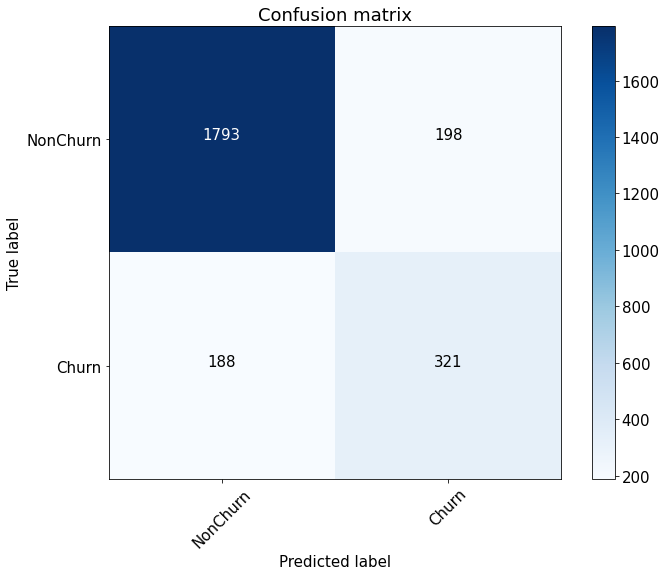

In [42]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_xgb>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_xgb.png")
plt.show()

Можно заметить, что мы очень сильно ошибаемся в сторону False Negatives, т.е у нас много тех, кто ушел в отток на самом деле, но при выбранном нами пороге в 0.38 мы не считаем их таковыми.

In [43]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]
print(f'{TP}(TP) {FP}(FP)\n{FN}(FN) {TN}(TN)')

321(TP) 198(FP)
188(FN) 1793(TN)


In [44]:
# precision = TP/(TP+FP)
# recall=TP/(TP+FN)
# fscore = (2 * precision * recall) / (precision + recall)

In [45]:
# print('F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (fscore,
#                                                      precision,
#                                                      recall))

In [46]:
models_results['model'].append('XGBoost')
models_results['precision'].append(precision[ix])
models_results['recall'].append(recall[ix])
models_results['f-score'].append(fscore[ix])
models_results['thresholds'].append(thresholds[ix])

In [47]:
pd.DataFrame(data=models_results).sort_values('precision', ascending=False)

,model,precision,recall,f-score,thresholds
0,RandomForest,0.653061,0.628684,0.640641,0.380000
1,XGBoost,0.619231,0.632613,0.625850,0.373318


### 1.2 -  логистическая регрессия

Добавим модель

In [48]:
from sklearn.linear_model import LogisticRegression  # Логистическая регрессия

In [49]:
from sklearn.model_selection import cross_val_score

In [50]:
classifier_lr = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression())
])

Обучим модель

In [51]:
#обучим пайплайн на всем тренировочном датасете
classifier_lr.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [52]:
#наши прогнозы для тестовой выборки
preds_lr = classifier_lr.predict_proba(X_test)[:, 1]
preds_lr[:10]

array([0.21099649, 0.32359512, 0.1500096 , 0.12721034, 0.14119933,
       0.58863226, 0.0614584 , 0.06447565, 0.40151029, 0.72394155])

In [53]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_lr)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.285175, F-Score=0.501, Precision=0.448, Recall=0.570


Confusion matrix, without normalization
[[1633  358]
 [ 220  289]]


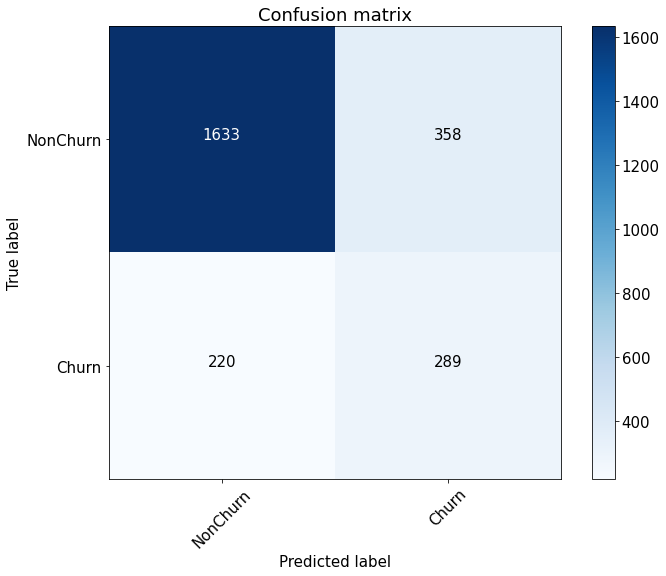

In [54]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_lr>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_lr.png")
plt.show()

In [55]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]
print(f'{TP}(TP) {FP}(FP)\n{FN}(FN) {TN}(TN)')

289(TP) 358(FP)
220(FN) 1633(TN)


In [56]:
models_results['model'].append('LogisticRegression')
models_results['precision'].append(precision[ix])
models_results['recall'].append(recall[ix])
models_results['f-score'].append(fscore[ix])
models_results['thresholds'].append(thresholds[ix])

<!-- Странный результат. <BR>
Выбирается порог=0.750600 (Best Threshold=0.750600, F-Score=nan, Precision=0.000, Recall=0.000)

Подберём порог вручную. -->

*************************************************************************

In [57]:
preds_lr_df=pd.DataFrame(preds_lr)
# preds_lr_df

In [58]:
# Best Threshold=0.285175, F-Score=0.501, Precision=0.448, Recall=0.570


th = 0.373318
# XGBoost
# [[1793  198]
#  [ 188  321]]

#
# LogisticRegression
#
# th = 0.373318
# [[1825  166]
#  [ 400  109]]
# Best Threshold=0.373318, F-Score=0.278, Precision=0.396, Recall=0.2141453831
# Best Threshold=0.000000, F-Score=0.338, Precision=0.204, Recall=1.000
# ! Best Threshold=0.373318, F-Score=0.454, Precision=0.523, Recall=0.4007858546

# th = 0.33
# # [[1991    0]
# #  [ 509    0]]
# # Best Threshold=0.330000, F-Score=0.344, Precision=0.389, Recall=0.3084479371
# # Best Threshold=0.000000, F-Score=0.338, Precision=0.204, Recall=1.000
# # ! Best Threshold=0.330000, F-Score=0.478, Precision=0.483, Recall=0.473

# th = 0.3385
# # [[1762  229]
# #  [ 359  150]]
# # Best Threshold=0.338500, F-Score=0.338, Precision=0.396, Recall=0.2946954813
# # Best Threshold=0.000000, F-Score=0.338, Precision=0.204, Recall=1.000
# # ! Best Threshold=0.338500, F-Score=0.475, Precision=0.488, Recall=0.464

# th = 0.34
# # [[1764  227]
# #  [ 361  148]]
# # Best Threshold=0.340000, F-Score=0.335, Precision=0.395, Recall=0.2907662083
# # Best Threshold=0.000000, F-Score=0.338, Precision=0.204, Recall=1.000
# # ! Best Threshold=0.340000, F-Score=0.476, Precision=0.491, Recall=0.462

# th = 0.35
# # [[1787  204]
# #  [ 374  135]]
# # Best Threshold=0.350000, F-Score=0.318, Precision=0.398, Recall=0.2652259332
# # Best Threshold=0.000000, F-Score=0.338, Precision=0.204, Recall=1.000
# # ! Best Threshold=0.350000, F-Score=0.470, Precision=0.502, Recall=0.442

# th = 0.36
# # [[1807  184]
# #  [ 381  128]]
# # Best Threshold=0.360000, F-Score=0.312, Precision=0.410, Recall=0.2514734774
# # Best Threshold=0.000000, F-Score=0.338, Precision=0.204, Recall=1.000
# # ! Best Threshold=0.360000, F-Score=0.468, Precision=0.518, Recall=0.426


# th = 0.37
# # [[1819  172]
# #  [ 396  113]]
# # Best Threshold=0.370000, F-Score=0.285, Precision=0.396, Recall=0.2220039293
# # Best Threshold=0.000000, F-Score=0.338, Precision=0.204, Recall=1.000
# # 207(TP) 194(FP)
# # 302(FN) 1797(TN)
# # ! Best Threshold=0.370000, F-Score=0.455, Precision=0.516, Recall=0.407


# th = 0.38
# # [[1838  153]
# #  [ 407  102]]
# Best Threshold=0.380000, F-Score=0.267, Precision=0.400, Recall=0.2003929273
# Best Threshold=0.000000, F-Score=0.338, Precision=0.204, Recall=1.000
# # 203(TP) 181(FP)
# # 306(FN) 1810(TN)
# # ! Best Threshold=0.380000, F-Score=0.455, Precision=0.529, Recall=0.399


# th = 0.385
# # [[1838  153]
# #  [ 407  102]]
# Best Threshold=0.380000, F-Score=0.267, Precision=0.400, Recall=0.2003929273
# Best Threshold=0.000000, F-Score=0.338, Precision=0.204, Recall=1.000
# # 199(TP) 175(FP)
# # 310(FN) 1816(TN)
# # ! Best Threshold=0.385000, F-Score=0.451, Precision=0.532, Recall=0.391

# th = 0.39
# # [[1854  137]
# #  [ 419   90]]
# # Best Threshold=0.390000, F-Score=0.245, Precision=0.396, Recall=0.1768172888
# # Best Threshold=0.000000, F-Score=0.338, Precision=0.204, Recall=1.000
# 195(TP) 171(FP)
# 314(FN) 1820(TN)
# # ! Best Threshold=0.390000, F-Score=0.446, Precision=0.533, Recall=0.383

preds_lr_df['y_score_class'] = preds_lr_df[0].apply(lambda x: 1 if x>=th else 0, 1)
#preds_lr_df

Confusion matrix, without normalization
[[1805  186]
 [ 305  204]]


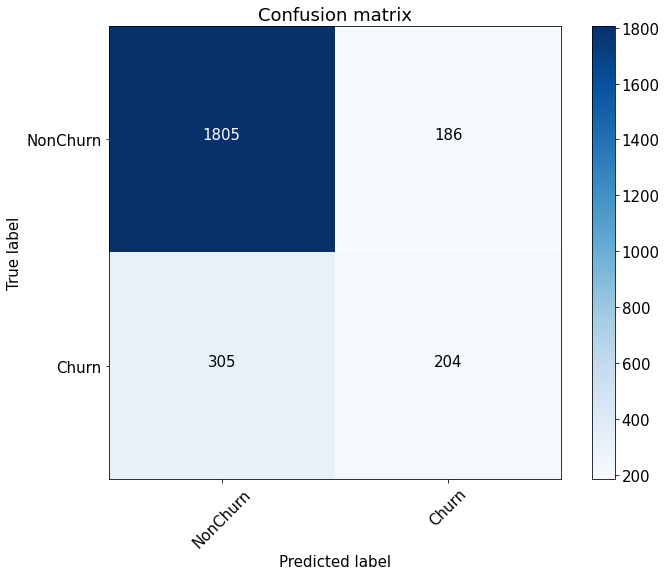

In [59]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_lr_df['y_score_class']>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_lr.png")
plt.show()

In [60]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]
print(f'{TP}(TP) {FP}(FP)\n{FN}(FN) {TN}(TN)')

204(TP) 186(FP)
305(FN) 1805(TN)


In [61]:
precision_1=TP/(TP+FP)
recall_1 = TP/(TP+FN)
fscore_1 = (2 * precision_1 * recall_1) / (precision_1 + recall_1)
print(th, fscore_1, precision_1, recall_1)

0.373318 0.45383759733036705 0.5230769230769231 0.40078585461689586


In [62]:
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (th, 
                                                                        fscore_1,
                                                                        precision_1,
                                                                        recall_1))

Best Threshold=0.373318, F-Score=0.454, Precision=0.523, Recall=0.401


In [63]:
# models_results['model'].append('LogisticRegression')
# models_results['precision'].append(precision_1)
# models_results['recall'].append(recall_1)
# models_results['f-score'].append(fscore_1)
# models_results['thresholds'].append(th)

### 

# 
## 2 Задание

Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

In [64]:
pd.DataFrame(data=models_results).sort_values('precision', ascending=False)

,model,precision,recall,f-score,thresholds
0,RandomForest,0.653061,0.628684,0.640641,0.380000
1,XGBoost,0.619231,0.632613,0.625850,0.373318
2,LogisticRegression,0.447531,0.569745,0.501296,0.285175


__RandomForest__:<br>
Матрица ошибок модели (__Confusion matrix__)<br>

    | 314 159  |
    | 195 1832 |
     
__XGBoost__:<br>
Матрица ошибок модели (__Confusion matrix__)<br>

    | 321 198  |
    | 188 1793 |
    
  
__LogisticRegression__:<br>
Матрица ошибок модели (__Confusion matrix__)<br>

    # с нормализацией параметров
    | 289 358  |
    | 220 1633 |

    # с нормализацией параметров
    # ручной подбор параметров
    | 236 248  |
    | 273 1743 |
   
    # без нормализации параметров
    | 150 229  | 
    | 395 1762 |


__Вывод__

Лучшей моделью по метрикам, является модель __RandomForest__:
- f-score = 0.640641
- precision = 0.653061
- recall = 0.64064

TP=314<br>
FP=159<br>
FN=195<br>
TN=1832<br>

Матрица ошибок модели (__Confusion matrix__)<br>

    | 321 198  |
    | 188 1793 |

# 
## 3 Задание

Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

### Оценка экономической эффективности

$$Экономическая эффективность =  Выручка - Траты$$

$$Выручка = TP * 2$$

$$Траты = (TP + FP) * 1$$


__RandomForest__

In [65]:
# Confusion matrix

# 314(TP) 159(FP)
# 195(FN) 1832(TN)

In [66]:
# Оценка экономической эффективности
TP = 314
NP = 159
# Выручка
revenue  = TP * 2
# Траты
spend = TP + NP
# Экономическая эффективность
E = revenue - spend

print(f'Выручка = {revenue}\nТраты={spend}\nЭкономическая эффективность={E}')

Выручка = 628
Траты=473
Экономическая эффективность=155


__XGBoost__

In [67]:
# Confusion matrix

# 321(TP) 198(FP)
# 188(FN) 1793(TN)

In [68]:
# Оценка экономической эффективности
TP = 321
NP = 198
# Выручка
revenue  = TP * 2
# Траты
spend = TP + NP
# Экономическая эффективност
E = revenue - spend

print(f'Выручка = {revenue}\nТраты={spend}\nЭкономическая эффективность={E}')

Выручка = 642
Траты=519
Экономическая эффективность=123


__LogisticRegression__

In [69]:
# Confusion matrix
# с нормализацией параметров
# 289(TP) 358(FP)
# 220(FN) 1633(TN)

# с нормализацией параметров
# ручной подбор параметров
# 236(TP) 248(FP)
# 273(FN) 1743(TN)

# без нормализации параметров
# 150(TP) 229(FP)
# 359(FN) 1762(TN)

In [70]:
# Оценка экономической эффективности
TP = 289
NP = 358
# Выручка
revenue  = TP * 2
# Траты
spend = TP + NP
# Экономическая эффективность
E = revenue - spend

print(f'Выручка = {revenue}\nТраты={spend}\nЭкономическая эффективность={E}')

Выручка = 578
Траты=647
Экономическая эффективность=-69


In [71]:
# Оценка экономической эффективности
# с нормализацией параметров
# ручной подбор параметров
TP = 236
NP = 273

# Выручка
revenue  = TP * 2
# Траты
spend = TP + NP
# Экономическая эффективность
E = revenue - spend

print(f'Выручка = {revenue}\nТраты={spend}\nЭкономическая эффективность={E}')

Выручка = 472
Траты=509
Экономическая эффективность=-37


### 
__Вывод__:<br>

Самая высокая экономическая эффективность оказалась у метода __RandomForest__:
- Выручка = 628
- Траты=473
- Экономическая эффективность=155


# 
## 4 Задание

(опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3

# 
## 5 Задание

(опционально) Еще раз провести оценку экономической эффективности

In [72]:
195*100/314

62.10191082802548